# LSTM Baseline Model Testing

## Imports and static variables

In [169]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [170]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc
import seaborn as sns

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [171]:
DATA_FOLDER = Path("../data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [172]:
MODEL = 'lstm'
MODE = 'classification'
MOVING_AVERAGES = [50, 20]
MA_FEATURES = [f'{ma}d MA' for ma in MOVING_AVERAGES]
INCLUDE_MOVING_AVERAGES = False
FEATURES = ['Trend', 'Close', 'Log Close', 'Daily Returns Percent', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5',
       'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
       'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA',
       'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM',
       'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC',
       'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2',
       'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent',
       'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F',
       'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD',
       'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F',
       'Dollar index', 'wheat-F', 'XAG', 'XAU']

if INCLUDE_MOVING_AVERAGES:
    FEATURES += MA_FEATURES

LEARNING_RATE = 0.00005
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 
RANDOM_LABEL_PERMUTATION = False

SEQ_LEN = 7
BATCH_SIZE = 4
HIDDEN_SIZE = 4
NUM_LAYERS = 1
OUTPUT_LOGITS = True
BIDIRECTIONAL = True

NUM_EPOCHS = 1000

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [174]:
sp = load_complete_time_series(REAL_DATA_FOLDER / "Processed_S&P.csv")

In [175]:
sp

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,1115.099976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,1132.989990,0.921723,0.016043,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,1136.520020,-0.375903,0.003116,0.016043,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,1137.140015,0.996234,0.000546,0.003116,0.016043,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,1141.689941,0.059932,0.004001,0.000546,0.003116,0.016043,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,2017-11-09,2584.620117,-0.017375,-0.003762,0.001444,-0.000189,0.001271,0.184895,0.945954,0.878967,...,-0.24,-0.62,-0.34,-0.27,-0.61,-0.44,-0.45,0.53,-0.26,0.32
1980,2017-11-10,2582.300049,-0.089962,-0.000898,-0.003762,0.001444,-0.000189,-0.214080,0.047654,0.275321,...,-0.27,-0.58,-0.20,-0.17,0.18,-0.07,-0.05,0.70,-0.71,-0.80
1981,2017-11-13,2584.840088,-0.024084,0.000984,-0.000898,-0.003762,0.001444,-0.242743,0.466802,0.774279,...,-0.38,0.72,-0.04,0.10,0.06,0.12,0.11,-1.85,0.83,0.16
1982,2017-11-14,2578.870117,0.070184,-0.002310,0.000984,-0.000898,-0.003762,-0.454319,0.140184,0.379126,...,-0.39,0.17,-0.21,-0.15,-0.70,-0.71,-0.70,1.00,0.01,0.24


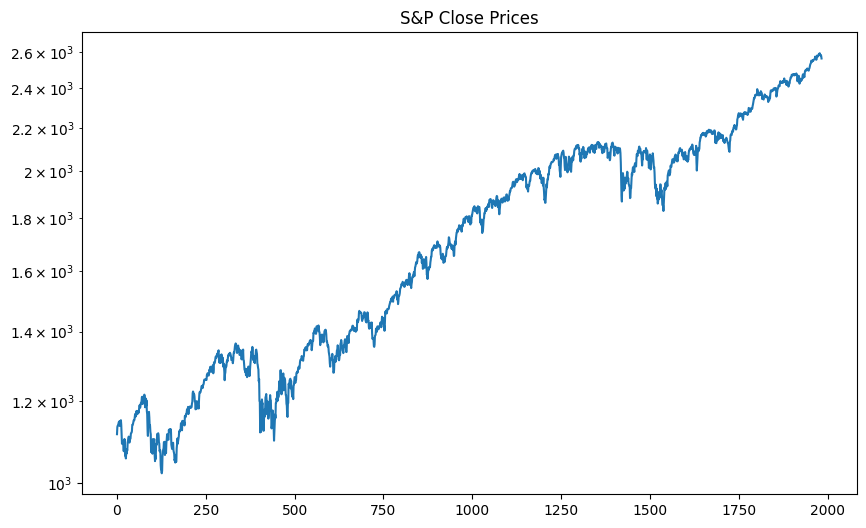

In [176]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(sp['Close'])
plt.yscale('log')
plt.title('S&P Close Prices')
plt.show()

## Feature Engineering

In [177]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
sp['Daily Returns Percent'] = sp['Close'].pct_change()

In [178]:
# get log values
sp['Log Close'] = np.log(sp['Close'])

In [179]:
# Create moving averages
if INCLUDE_MOVING_AVERAGES:
    for ma in MOVING_AVERAGES:
        sp[f'{ma}d MA'] = sp['Close'].rolling(window=ma).mean()

In [180]:
# set trend to 1 if daily return > 1, else -1
sp['Trend'] = sp['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [181]:
sp = sp.dropna()
sp = sp[FEATURES]

## Preprocessing

In [182]:
sp_np = sp.to_numpy()

In [183]:
sp_np[:10]

array([[ 0.00000000e+00,  1.16590002e+03,  7.06124862e+00,
        -1.58772507e-02,  2.58439793e-01, -1.58772507e-02,
         7.24374500e-03,  2.02748480e-03, -3.64138620e-03,
        -3.30833919e-01,  4.43680724e-01,  1.58578668e+00,
         2.29166983e+00,  1.16830357e+03,  1.15644663e+03,
         1.13226929e+03,  1.12150254e+03,  1.40000000e-01,
         1.40000000e-01,  1.80000000e-01,  1.11000000e+00,
         2.50000000e+00, -4.20178184e-02, -2.06619126e-02,
         4.70000000e+00,  5.75000000e+00, -1.20133686e-02,
         4.23658230e-03,  1.56027253e-02,  6.02936300e-05,
        -2.67610008e-02, -2.98972858e-02, -1.10769231e-02,
        -8.92577500e-03, -1.33508373e-02, -2.78853602e-02,
        -1.28669878e-02, -1.75014487e-02, -7.12741640e-03,
        -6.72182810e-03, -3.98057620e-03, -1.48128947e-02,
         1.25418566e-02, -1.76202956e-02,  1.57774598e-02,
        -2.25028951e-02, -1.94753991e-02,  2.36000000e+00,
         2.36000000e+00,  2.32000000e+00,  0.00000000e+0

In [184]:
sp_train, sp_test = train_test_split(sp_np, FIRST_SPLIT)
sp_test, sp_val = train_test_split(sp_test, SECOND_SPLIT)

In [185]:
sp_train.shape, sp_test.shape, sp_val.shape

((891, 85), (111, 85), (112, 85))

In [186]:
# account for moving averages
if INCLUDE_MOVING_AVERAGES:
    sp_test = sp_test[max(MOVING_AVERAGES):]
    sp_val = sp_val[max(MOVING_AVERAGES):]

In [187]:
scaler = Scaler(sp_train, scale_features_individually=False)

In [188]:
sp_train_scaled = scaler.scale_data(sp_train)
sp_test_scaled = scaler.scale_data(sp_test)
sp_val_scaled = scaler.scale_data(sp_val)

In [189]:
sp_train_seq_scaled = split_data_into_sequences(sp_train_scaled, SEQ_LEN)
sp_test_seq_scaled = split_data_into_sequences(sp_test_scaled, SEQ_LEN)
sp_val_seq_scaled = split_data_into_sequences(sp_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (885, 7, 85)
Shape of the data after splitting into sequences: (105, 7, 85)
Shape of the data after splitting into sequences: (106, 7, 85)


In [190]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(sp_train_seq_scaled, sp_test_seq_scaled, sp_val_seq_scaled)

In [191]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [192]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [193]:
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()
criterion_binary_logits = nn.BCEWithLogitsLoss()
criterion_binary = nn.BCELoss()

In [194]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []
validation_loss_accumulation_callback = ValidationLossAccumulationCallback(val_losses)

In [195]:
if MODEL == 'lstm':

    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=X_train.shape[2], # number of features
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion_binary_logits if OUTPUT_LOGITS else criterion_binary,
                        optimizer=optimizer,
                        device=device,
                        verbose=True)
        
elif MODEL == 'xgb':

    model = XGBClassifier(
        objective='binary:logistic',      
        max_depth=10,       
        learning_rate=0.00005,
        n_estimators=1000,
        verbosity=2,
        early_stopping_rounds=10,
        callbacks=[validation_loss_accumulation_callback], 
        reg_alpha=0.01,
        reg_lambda=0.01
    )
    
    model.fit(
        X_train.reshape((X_train.shape[0], -1)), 
        y_train,
        eval_set=[(X_val.reshape((X_val.shape[0], -1)), y_val)]
    )

elif MODEL == 'random_forest':
    model = RandomForestClassifier(
        n_estimators=1000,  # Anzahl der Bäume
        max_depth=10,       # Maximale Tiefe der Bäume
        random_state=42,    # Zufallsstartwert für Reproduzierbarkeit
        verbose=1           # Verbose-Level für Ausgabe
    )

    model.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

Epoch: 1
Training Loss: 0.7072291320562363
Validation Loss: 0.7080379040152939
Validation Accuracy: 46.2962962962963
**************************************************
Epoch: 2
Training Loss: 0.7034839743375778
Validation Loss: 0.704911779474329
Validation Accuracy: 46.2962962962963
**************************************************
Epoch: 3
Training Loss: 0.700283582508564
Validation Loss: 0.702372756269243
Validation Accuracy: 46.2962962962963
**************************************************
Epoch: 4
Training Loss: 0.697664139866829
Validation Loss: 0.7003363150137442
Validation Accuracy: 46.2962962962963
**************************************************
Epoch: 5
Training Loss: 0.6955624541640282
Validation Loss: 0.6987046820146067
Validation Accuracy: 46.2962962962963
**************************************************
Epoch: 6
Training Loss: 0.6938956108689308
Validation Loss: 0.6973912760063454
Validation Accuracy: 45.370370370370374
*********************************************

Text(0.5, 1.0, 'Validation Accuracy')

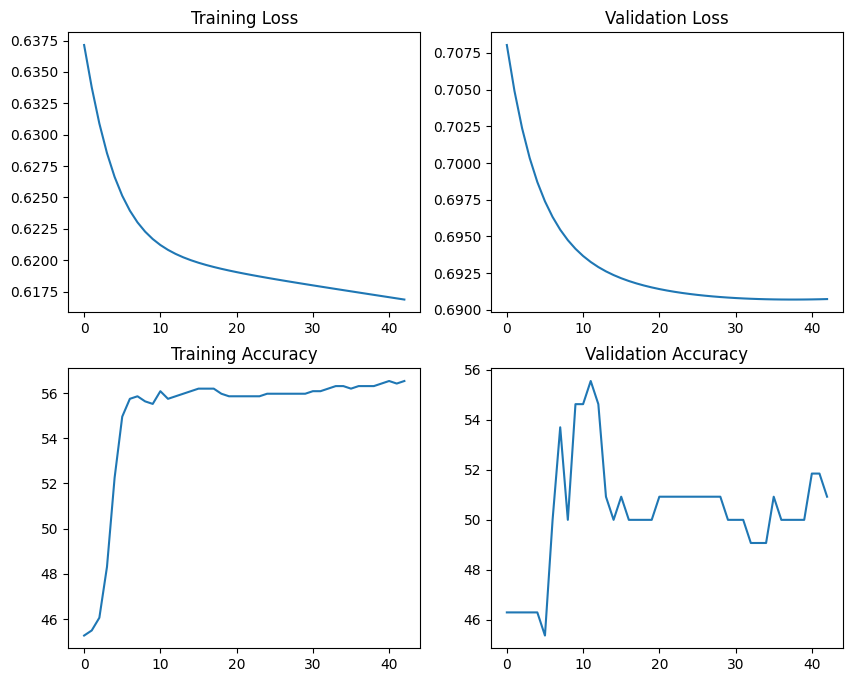

In [196]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

## Evaluation

In [101]:
if MODEL == 'lstm':

    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

elif MODEL == 'xgb':
        
    test_preds = model.predict(X_test.reshape((X_test.shape[0], -1)))

elif MODEL == 'random_forest':
        
    test_preds = model.predict(X_test.reshape((X_test.shape[0], -1)))

In [102]:
test_preds.max()

tensor(1.)

In [103]:
100 / len(y_test) * np.count_nonzero(y_test == 0)

45.99236641221374

In [104]:
# calculate accuracy and loss for test set
test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds).reshape(-1, 1))
test_loss = criterion_binary(torch.tensor(test_preds, dtype=torch.float32).reshape(-1, 1), y_test).item()

# calculate accuracy and loss for predicting always zeros
zeros_acc = accuracy(y_true=y_test, y_pred=torch.zeros_like(torch.tensor(y_test)))
zeros_loss = criterion_binary(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()

print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')
print(f'Zero Accuracy: {zeros_acc}')
print(f'Zero Loss: {zeros_loss}')

Test Accuracy: 54.007633587786266
Test Loss: 45.992366790771484
Zero Accuracy: 45.99236641221374
Zero Loss: 54.007633209228516


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/3958726577.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds).reshape(-1, 1))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/3958726577.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = criterion_binary(torch.tensor(test_preds, dtype=torch.float32).reshape(-1, 1), y_test).item()
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/3958726577.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

In [105]:
torch.randn(3, 2)

tensor([[ 0.9035,  0.7144],
        [-1.3224, -0.2801],
        [ 0.4168, -1.9139]])

### dummy testing

In [106]:
dummy = MeanRegressor()

In [107]:
dummy_preds = dummy.make_predictions(aapl_test_dummy, returns=True if 'Daily Returns' in FEATURES else False)

In [108]:
loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
loss

# plot train data
plt.title(f'Dummy Model Test Data Predictions ({test_range[1]-test_range[0]} Days)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(dummy_preds[test_range[0]: test_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_13166/2832236691.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1048, 1])) that is different to the input size (torch.Size([1048])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


NameError: name 'test_range' is not defined